# Случайные процессы. Прикладной поток.
## Практическое задание 5

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 5"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `5.N.ipynb` и `5.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.

Варианты:

 0 . http://ita.ee.lbl.gov/html/contrib/ClarkNet-HTTP.html
 
 1 . http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html
 
 2 . http://ita.ee.lbl.gov/html/contrib/Calgary-HTTP.html
 
 3 . http://ita.ee.lbl.gov/html/contrib/Sask-HTTP.html

Нужно выбрать вариант N mod 4, где N — ваш номер из таблицы с оценками.

**Задание:**

1. Загрузите в Питоне данные, соответствующие вашему варианту. Возможно, будет удобнее воспользоваться библиотекой pandas, в частности функцией read_csv. Некоторые записи в данных могут иметь неправильный формат, поэтому сначала файл с данными придется преобразовать. В процессе преобразовании можно проигнорировать не более 1% строк, в которых указана дата (если будете удалять, напечатайте долю удаленных строк). Строки, в которых дата не указана, нужно удалить.

2. Переведите дату в timestamp-число с помощью библиотеки datetime. Например, дата 24/Oct/1994:13:41:41 преобразуется в число 782995301 с помощью кодa from datetime import datetime datetime.strptime("24/Oct/1994:13:41:41", "%d/%b/%Y:%H:%M:%S").timestamp() Подробнее читайте в документациях к библиотекам datetime и time.

3. Запросы, происходящие в некоторые моменты времени, образуют пуассоновский процесс, смысл которого — количество запросов, обработанных сервером к текущему моменту времени. Нарисуйте графики траектории этого пуассоновского процесса за все время и за первые сутки. Нарисуйте так же аналогичные графики составного пуассоновского процесса, взяв в качестве значений количество байт (bytes in the reply).При построении графиков используйте код с семинара.

4. Проверьте полученный пуассоновский процесс на однородность за все время, а так же за некоторые другие интервалы времени (месяц, неделя, сутки, час). Имеются ли интервалы, на которых процесс однороден? Чтобы проверить корректность работы реализованных критериев, можно проверить их на сгенерированных данных. Код для генерации можно взять с семинара.

5. Постройте оценку функции интенсивности следующим образом. Разбейте весь временной интервал на небольшие равные по длине интервалы с достаточным количеством событий в каждом интервале (например, интерваля длинною в час). На каждом интервале оцените значение интенсивности процесса, считая его однородным на данном интервале. В какие моменты времени наблюдается наибольшая интенсивность?

6. Для получения дополнительных баллов исследуйте, есть ли зависимость интенсивности от типа хоста (host); есть ли зависимость объема запроса в байтах от времени; какой пропускной способности должны быть серверы, чтобы обрабатывать все поступающие запросы. При проведении исследования учитывайте все особенности проверки статистических гипотез. Не забывайте делать выводы.

Дополнительно:
В пятом практическом задании чтобы не ждать трое суток, пока нарисуется график траектории всего процесса, постройте точные графики траекторий пуассоновского процесса для первых 100 и 1000 событий. Для всего интервала времени постройте приближенный график с помощью plt.plot(моменты времени, range).

__________________________

### Работа начинается здесь

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.stats as sps
from datetime import datetime
from statsmodels.sandbox.stats.multicomp import multipletests

____________

Скачаем данные в Питоне, что ли.

In [3]:
N = 30
print("Вариант: ", N % 4)

Вариант:  2


In [4]:
url = "ftp://ita.ee.lbl.gov/traces/calgary_access_log.gz"
fname = "calgary_access_log.gz"
unzip_fname = fname[:-3]


!wget -O $fname $url
!gunzip $fname

--2017-10-15 14:48:47--  ftp://ita.ee.lbl.gov/traces/calgary_access_log.gz
           => «calgary_access_log.gz»
Распознаётся ita.ee.lbl.gov (ita.ee.lbl.gov)... 131.243.2.164, 2620:83:8000:102::a4
Подключение к ita.ee.lbl.gov (ita.ee.lbl.gov)|131.243.2.164|:21... соединение установлено.
Выполняется вход под именем anonymous ... Выполнен вход в систему!
==> SYST ... готово.    ==> PWD ... готово.
==> TYPE I ... готово.  ==> CWD (1) /traces ... готово.
==> SIZE calgary_access_log.gz ... 5435681
==> PASV ... готово.    ==> RETR calgary_access_log.gz ... готово.
Размер (байт): 5435681 (5,2M) (не достоверно)

calgary_access_log. 100%[===================>]   5,18M   193KB/s    in 29s     

2017-10-15 14:49:19 (185 KB/s) - «calgary_access_log.gz» сохранён [5435681]

gzip: calgary_access_log already exists; do you wish to overwrite (y or n)? ^C


___________________
В файле есть строки без даты:

<code>
local - - [24/Oct/1994:15:01:37 -0600] "GET index.html HTTP/1.0" 200 780
local - - [24/Oct/1994:15:01:48 -0600] "GET 42.html HTTP/1.0" 200 3070
local - - [24/Oct/1994:15:02:30 -0600] "GET index.html HTTP/1.0" 200 3185
local - - [24/Oct/1994:15:02:31 -0600] "GET 2.gif HTTP/1.0" 200 2555
local 780     index.html
</code>

Удалим их, в условии сказано, что такие можно удалить все.
Более того, некоторые строки в данных невозможно прочесть в текстовом режиме,
ни в utf-8, ни в ascii, только в cp1251.
Поэтому будем читать бинарно. (Можно было выставить encoding в open, но постоянно обаруживались новые косяки в данных)
(как оказалось, таких три строки)
______

Позднее выяснилось, что в данных бывет вот такая прелесть
<code>
remote - - [27/Oct/1994:18:51:50 -0600] "GET index.html 200 3185
</code>
Видите вторую пару кавычек?
______
На самом деле, она в таких строках:
<code>
local - - [31/Oct/1994:13:23:41 -0700] "GET 841.html" HTTP/1.0" 404 -
</code>
___________
Такое - тоже норма.
<code>
local - - [02/Sep/1995:16:33:27 -0600] "GET 2337.gif HTTP/1.0" 200meikai - - [02/Sep/1995:16:33:27 -0600] "GET /local_interest/class_info/453/Lab3/Pics/15-small.gif HTTP/1.0" 200 5864
</code>
(это одна строка)
___________

In [5]:
regexp_date = re.compile(".*\[\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4}\].*")
regexp_all_other = re.compile(
    r"\w* - - \[\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4}\][^\"]*\"[^\"]*\" [\d-]* [^\"]*"
)
prepared_fname = "prepared_" + unzip_fname

log = False
log_strange = False
bad_code = 0             
has_no_date = 0
strange_strings = 0
total_lines = 0

with open(unzip_fname, "rb") as f_read:
    with open(prepared_fname, "w") as f_write:
        read_lines = f_read.readlines()
        total_lines = len(read_lines)
        if log:
            print("Cтрок прочитано всего: = ", total_lines)
        for i in range(len(read_lines)):
            try:
                line = read_lines[i].decode("cp1251")
            except UnicodeDecodeError as e:
                print("Недекодируемая строка номер %d. Удалено." % (i))
                bad_code += 1
                
            if not regexp_date.match(line) is None:
                if (not regexp_all_other.match(line) is None) and  (
                    line in regexp_all_other.findall(line)):
                    f_write.write(line)
                else:
                    if log_strange: 
                        print("Что-то странное:", line)
                    strange_strings += 1
            else:
                if log: 
                    print("Нет даты. Удалено:", line)
                has_no_date += 1
            # print(i)
                      
print("bad_code = {} ({}%), has_no_date = {} ({}%)," +
      " strange_strings = {} ({}%), total_lines = {} ({}%)".format(
            bad_code, round(bad_code / total_lines * 100, 3),
            has_no_date,round(has_no_date / total_lines * 100, 3),
            strange_strings,round(strange_strings / total_lines * 100, 3),
            total_lines, round(total_lines / total_lines * 100, 3)))

bad_code = 0 (0.0%), has_no_date = 1614 (0.222%), strange_strings = 328 (0.045%), total_lines = 726739 (100.0%)


In [6]:
read_lines[603041]

b'remote - - [01/Sep/1995:08:09:06 -0600] "GET 9712.gif HTTP/1.0" 200 1167\n'

In [7]:
url = "ftp://ita.ee.lbl.gov/traces/calgary_access_log.gz"
fname = "calgary_access_log.gz"
unzip_fname = fname[:-3]
prepared_fname = "prepared_" + unzip_fname
raw_data = pd.read_csv(prepared_fname, sep=" ", header=None)

In [8]:
raw_data.head()

,0,1,2,3,4,5,6,7
0,local,-,-,[24/Oct/1994:13:41:41,-0600],GET index.html HTTP/1.0,200,150
1,local,-,-,[24/Oct/1994:13:41:41,-0600],GET 1.gif HTTP/1.0,200,1210
2,local,-,-,[24/Oct/1994:13:43:13,-0600],GET index.html HTTP/1.0,200,3185
3,local,-,-,[24/Oct/1994:13:43:14,-0600],GET 2.gif HTTP/1.0,200,2555
4,local,-,-,[24/Oct/1994:13:43:15,-0600],GET 3.gif HTTP/1.0,200,36403


Почти то, что надо. Заметим, что мы удалили меньше процента строк, даже если учитывать строки без даты.

Освежим в памяти формат данных и начнём приведение их к нормальному виду:

1. **host making** the request. Hosts are identified as either local or remote where local is a host from the University of Calgary, and remote is a host from outside of the University of Calgary domain.
2. **timestamp** in the format "DAY MON DD HH:MM:SS YYYY", where DAY is the day of the week, MON is the name of the month, DD is the day of the month, HH:MM:SS is the time of day using a 24-hour clock, and YYYY is the year. The timezone is -0700 between 30/Oct/1994:01:30:57 and 02/Apr/1995:03:03:26. For all other requests, the timezone is -0600.
3. **filename** of the requested item. Paths have been removed. Modified filenames consist of two parts: num.type , where num is a unique integer identifier, and type is the extension of the requested file.
4. **HTTP reply code**
5. **bytes in the reply** 

Не забудем про часовой пояс и про типы столбцов.
В столбце "bytes in the reply" есть отсутствующие данные. Применяя стандартный метод, заменим их на среднее значение по присутствующим данным. (хороший вопрос, какое среднее брать: медиану или среднее арифметическое (мода не очень уместна), мы выберем последнее)

In [9]:
data = pd.DataFrame()
data["host_making"] = raw_data[0].astype(str)

def time_traveler(x):
    parse = x.split(" ")
    time = parse[0][1:]
    timezone = parse[1][:-1]
    shift = 0
    if (timezone == "-0600"):
        pass
    elif (timezone == "-0700"):
        shift = - 60 * 60
    else:
        print("Wrong timezone:", time, timezone)
        
    return int(datetime.strptime(time, "%d/%b/%Y:%H:%M:%S").timestamp() + shift)

data["timestamp"] = (raw_data[3] + " " + raw_data[4]).apply(time_traveler).astype(int)
data["filename"]  = raw_data[5].astype(str)

In [10]:
data["http_reply_code"] = raw_data[6].astype(str)  # здесь есть пропуски "-"

reply_bytes_filled = np.array([int(x) for x in raw_data[7] if x != "-"])
mean_reply_bytes_filled = int(reply_bytes_filled.mean())
print("reply_bytes присутствует в {} ({}%)".format(
    len(reply_bytes_filled), round(len(reply_bytes_filled) / total_lines * 100, 3)))
print("Среднее число байт среди заполненных = ", mean_reply_bytes_filled)
reply_bytes = [int(x) if x != "-" else mean_reply_bytes_filled for x in raw_data[7]]
data["reply_bytes"] = reply_bytes

reply_bytes присутствует в 666785 (91.75%)
Среднее число байт среди заполненных =  11916


In [11]:
data.head()

,host_making,timestamp,filename,http_reply_code,reply_bytes
0,local,782995301,GET index.html HTTP/1.0,200,150
1,local,782995301,GET 1.gif HTTP/1.0,200,1210
2,local,782995393,GET index.html HTTP/1.0,200,3185
3,local,782995394,GET 2.gif HTTP/1.0,200,2555
4,local,782995395,GET 3.gif HTTP/1.0,200,36403


In [12]:
print("Итого осталось строк = {}, ({}%)".format(
    data.shape[0], round(data.shape[0] / total_lines * 100, 3)))

data.info()

Итого осталось строк = 724797, (99.733%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724797 entries, 0 to 724796
Data columns (total 5 columns):
host_making        724797 non-null object
timestamp          724797 non-null int64
filename           724797 non-null object
http_reply_code    724797 non-null object
reply_bytes        724797 non-null int64
dtypes: int64(2), object(3)
memory usage: 27.6+ MB


___________________________
### Обработка данных

Нарисуем точный график для первых 100, 1000 событий, 24 часов и приближённый для всех событий.

Будем считать, что отсчёт времени начинается за секунду до прихода первого запроса.

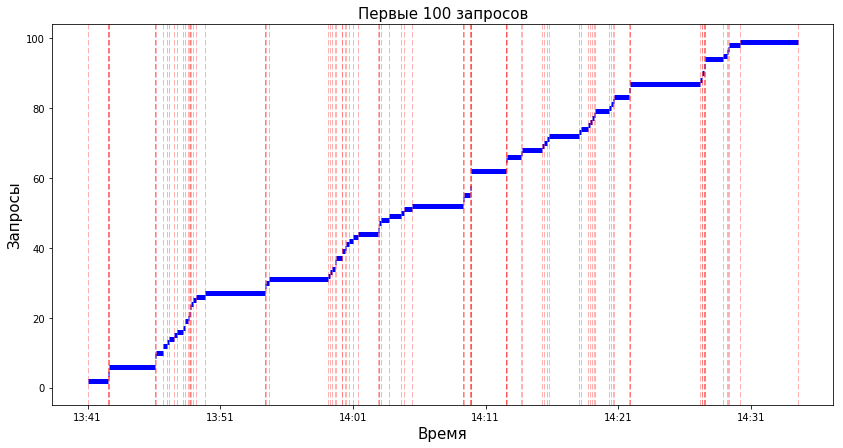

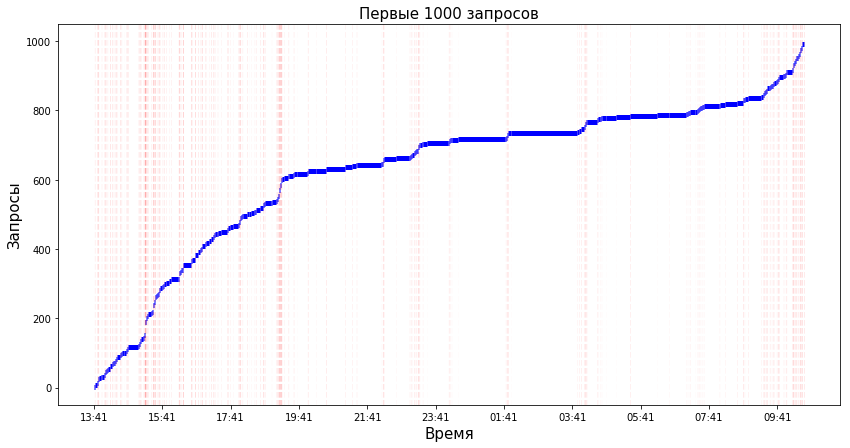

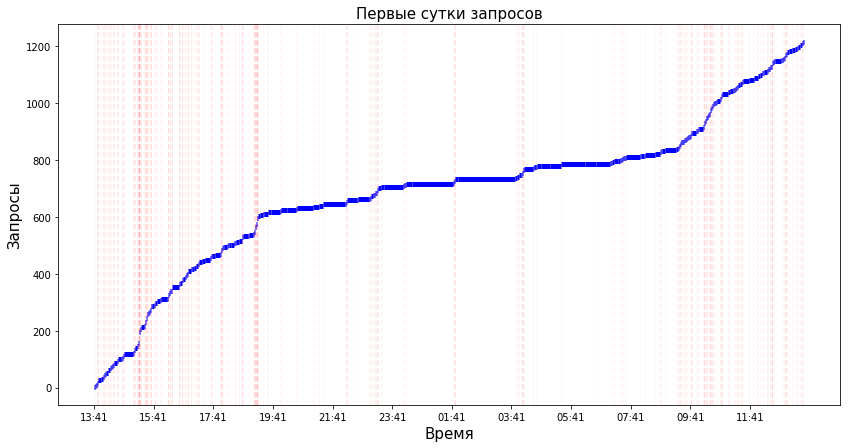

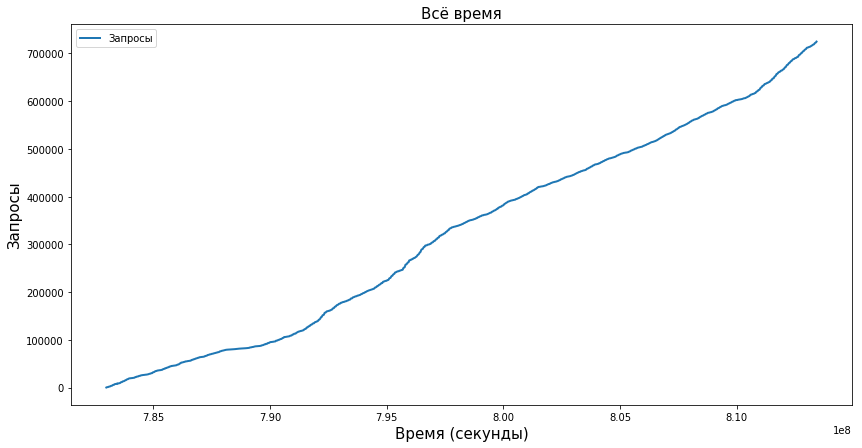

In [19]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%H:%M")

def plot_process(jumps, complex_process=None,
                 vlines=True, alpha=0.3,
                 title="", start_time=None,
                 step=2*60*60):
    
    plt.figure(figsize=(14, 7))
    last_request_time = 0
    last_level = 0
    i = 0
    while (i < len(jumps)): 
        # выделяем группу [i, i + shift - 1] запросов с одинаковым веременем
        # и рисуем линию от времени предыдущей группы до времени текущей группы
        # с уровнем, соответствующим предыдущей группе
        shift = 0
        while (i + shift < len(jumps)) and (jumps[i] == jumps[i + shift]):
            shift += 1

        if complex_process is None:  
            plt.hlines(last_level, last_request_time, jumps[i + shift - 1], lw=5, color='blue')
            last_level = i + shift
        else:
            plt.hlines(last_level, last_request_time, jumps[i + shift - 1], lw=5, color='blue')
            last_level = complex_process[:i + shift].sum()
        
        if vlines:
            plt.axvline(jumps[i], ls='--', color='red', lw=1, alpha=alpha)
        
        last_request_time = jumps[i + shift - 1]
        i += shift
    plt.title(title, fontsize=15)
    if complex_process is None:
        plt.ylabel("Запросы", fontsize=15)
    else:
        plt.ylabel("Байты", fontsize=15)
        
    plt.xlabel("Время", fontsize=15)
    if not start_time is None:
        labels = [format_time(x) for x in start_time + np.arange(0, jumps[-1], step)]
        
        plt.xticks(np.arange(0, jumps[-1], step), labels)
    plt.show()
    
    
times = (data["timestamp"].values -
        data["timestamp"].values.min() + 1)

plot_process(times[:100],
             title="Первые 100 запросов",
             start_time=data["timestamp"][0],
             step = 10 * 60)
plot_process(times[:1000],
             alpha=0.01,
             title="Первые 1000 запросов",
             start_time=data["timestamp"][0])
plot_process(times[times < 24 * 60 * 60 + 1],
             alpha=0.01,
             title="Первые сутки запросов",
             start_time=data["timestamp"][0])

plt.figure(figsize=(14, 7))
plt.plot(data["timestamp"], np.arange(len(data["timestamp"])), lw=2, label="Запросы")
plt.title("Всё время", fontsize=15)
plt.ylabel("Запросы", fontsize=15)
plt.xlabel("Время (секунды)", fontsize=15)
plt.legend()
plt.show()

**Комментарий:**
Заметим, что на графике за одни сутки интенсивность в светлое ~(09:00 - 19:00) и в тёмное время суток разная.
Нарисуем аналогичные графики составного пуассоновского процесса, взяв в качестве значений количество байт.

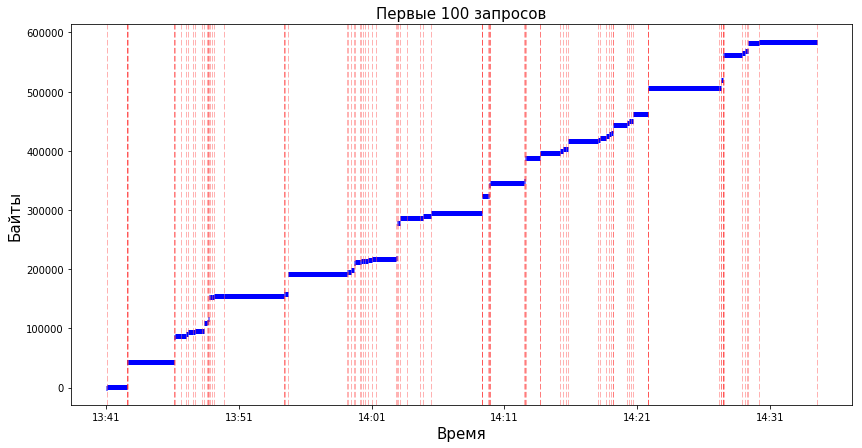

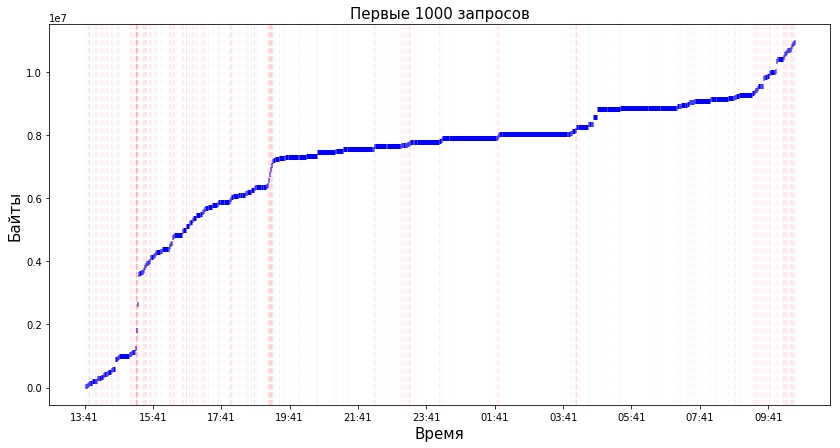

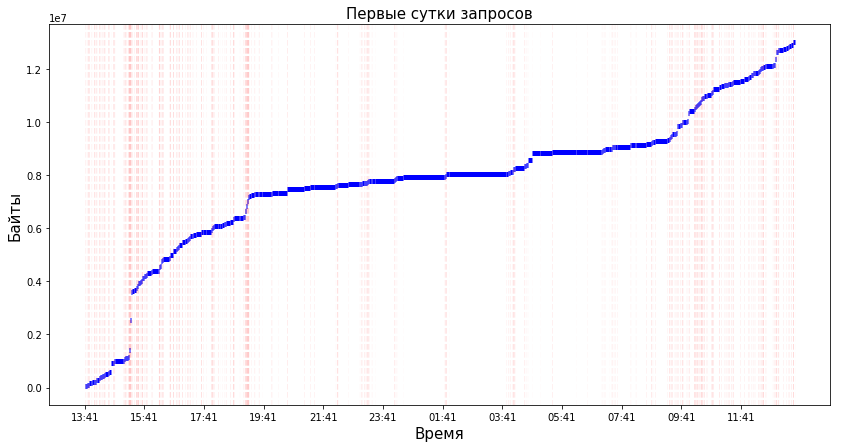

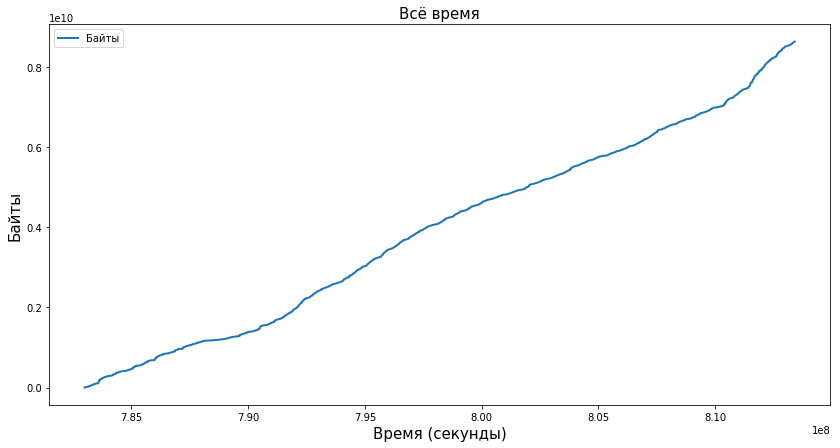

In [20]:
reply_bytes = data["reply_bytes"].values
plot_process(times[:100],
             complex_process=reply_bytes,
             title="Первые 100 запросов",
             start_time=data["timestamp"][0],
             step = 10 * 60)
plot_process(times[:1000],
             complex_process=reply_bytes,
             alpha=0.01,
             title="Первые 1000 запросов",
             start_time=data["timestamp"][0])
plot_process(times[times < 24 * 60 * 60 + 1],
             complex_process=reply_bytes,
             alpha=0.01,
             title="Первые сутки запросов",
             start_time=data["timestamp"][0])

plt.figure(figsize=(14, 7))
plt.plot(data["timestamp"], reply_bytes.cumsum(), lw=2, label="Байты")
plt.title("Всё время", fontsize=15)
plt.ylabel("Байты", fontsize=15)
plt.xlabel("Время (секунды)", fontsize=15)
plt.legend()
plt.show()

Разрывы на втором графике действительно есть:

In [21]:
format_time(data["timestamp"][data["reply_bytes"][:1000].argmax()]), data["reply_bytes"][:1000].max()

('15:15', 559259)

## Вторая половина задания

### Проверка на однородность

Напишем, с использование материалов первого семинара, функцию проверки на однородность.
При этом, вспоминая замечания о применимости критерия хи-квадрат из первого семинара, сделаем опциональную корректировку по размеру: можно дополнительно указать размер подвыборки, которую нужно выбрать (случайно, с возвращением) и по которой нужно проводить анализ. При таком выборе подвыборки пропорции должны измениться не значительно и, по этой подвыборке

In [20]:
def chisquare_format(result, alpha=0.05, log=True):
    if log:
        print("Статистика критерия хи-квадрат:", round(result.statistic, 3))
        print("p-value: ", round(result.pvalue, 3))
    if result.pvalue < alpha:
        if log:
            print("Гипотеза отвергается.")
        return True  # да, отверглась
    else:
        if log:
            print("Гипотеза не отвергается.")
        return False  # нет, не отверглась
        
def poission_process_uniformity_check(jumps, division=None,
                                      size_correction=None,
                                      log=True, hist_log=False):
    """Функция проверяет процесс на однородность, когда
    даны его прыжки jumps, методом разделения всего времени
    на division равных отрезков и проверкой гипотезы о том, что
    число событий в каждом отрезке одинаково с помощью теста 
    хи-квадрат. При size_correction=(threshold, sub_size)
    из выборки выбирается подвыборка размера sub_size для коррекции,
    если размер всей выборки больше threshold, т.к. критерий
    плохо работает на больших выборках. По умолчанию этого
    не происходит.
    По умолчанию division выставляется равным log_2(размер
    выборки после усечения)"""
    
    jumps = np.array(jumps)
    if (not size_correction is None):
        if (len(jumps) > size_correction[0]):
            jumps = np.array(
                jumps[sps.randint.rvs(0, len(jumps), size=size_correction[1])]
            )
    
    if division is None:
        division = int(np.log2(len(jumps)) + 0.5)  # математическое округление
        # в учебных материалах некоторого вуза советовали
        # выбирать примерно такое разбиение при произвольном N
        # При обычном размере выборки в 150 элементов
        # имеем те же 7 групп, что и обычно.
        
    events = np.histogram(jumps, bins=division)
    expected = np.ones(division) * len(jumps) / division
    if hist_log:
        print(events[0])
        print(expected)
    #print(events2)
    # assert (events[0] == events2).all()
    return chisquare_format(sps.chisquare(events[0], expected), log=log)

Для тестирования, как и предлагается, используем код с семинара, изучив его. Предлагается брать код, основанный на условном распределении моментов скачков при условии $N_t = n$

In [21]:
def get_poisson_process(T = 20, l = 1):
     # l - интенсивность
    N_T = sps.poisson(mu=l*T).rvs()
    jumps = sps.uniform(loc=0, scale=T).rvs(size=N_T)  # моменты скачков (не упоряд.)
    jumps.sort()
    return jumps

In [26]:
for size_correction in [None, (1000, 300)]:
    rejected = 0
    not_rejected = 0
    cutted = 0
    for T in [70, 100, 150, 200, 300, 500, 1000, 100000, 1000000]:
            for l in [0.5, 1, 3, 5, 7, 8]:
                jumps = get_poisson_process(T=T, l=l)
                if (len(jumps) >= 50):  # требование теста
                    if ((not size_correction is None) and
                        (len(jumps) > size_correction[0])):
                        cutted += 1
                        
                    if poission_process_uniformity_check(jumps,
                        size_correction=size_correction, log=False):
                        rejected += 1
                    else:
                        not_rejected += 1

    if size_correction is None:
        print("Без коррекции по размеру.", end=" ")
    else:
        print(("Коррекция по размеру: c размера %d " +
              "начинаем брать подвыборку размера %d") %
              size_correction,end = ". ")
    print("Отвергнута {} из {} раз ({}%). Обрезано {} выборок".format(
        rejected, rejected + not_rejected,
        round(rejected / (rejected + not_rejected) *100, 2),
        cutted))

Без коррекции по размеру. Отвергнута 4 из 53 раз (7.55%). Обрезано 0 выборок
Коррекция по размеру: c размера 1000 начинаем брать подвыборку размера 300. Отвергнута 2 из 53 раз (3.77%). Обрезано 28 выборок


**Комментарий:**
Полученные значение меньше (сравнимы c) 0.05 и их можно считать приемлемым. В целом, значения часто совпадают, до метод с усечением выборки реже отвергает верную (здесь - именно верную) гипотезу.

Подкинем теперь посмотрим на результаты при неоднородном процессе.

In [27]:
def get_not_uniform_poisson_process(T = 72, l = 5 * 2.5):
    # T = 72 - трое суток
    # l = 5 * 2.5 максимальное значение интенсивности

    S = 0
    xi = [0]
    while S < T:
        value = sps.expon(scale=1/l).rvs()
        if sps.uniform.rvs() < 5 * (np.sin(S * np.pi/12 + 10) + 1.5) / l:
            xi.append(value)
        else:
            xi[-1] += value
        S += value
    jumps = np.cumsum(xi)
    jumps[0] = 0
    return jumps

In [42]:
jumps_list = []
for T in [70, 100, 150, 300, 400, 500, 700, 1000]:
    # этот блок работает медленнее, ограничим максимальный размер
        for l in [9, 10, 11, 12]:
            jumps_list.append(get_not_uniform_poisson_process(T=T, l=l))
            
for size_correction in [None, (1000, 300)]:
    rejected = 0
    not_rejected = 0
    cutted = 0
    for jumps in jumps_list:
                if (len(jumps) >= 50):  # требование теста
                    if ((not size_correction is None) and
                        (len(jumps) > size_correction[0])):
                        cutted += 1
                        
                    if poission_process_uniformity_check(jumps,
                            size_correction=size_correction, log=False):
                        rejected += 1
                    else:
                        not_rejected += 1

    if size_correction is None:
        print("Без коррекции по размеру.", end=" ")
    else:
        print(("Коррекция по размеру: c размера %d " +
              "начинаем брать подвыборку размера %d") %
              size_correction,end = ". ")
    print("Отвергнута {} из {} раз ({}%). Обрезано {} выборок".format(
        rejected, rejected + not_rejected,
        round(rejected / (rejected + not_rejected) *100, 2),
        cutted))

Без коррекции по размеру. Отвергнута 21 из 32 раз (65.62%). Обрезано 0 выборок
Коррекция по размеру: c размера 1000 начинаем брать подвыборку размера 300. Отвергнута 13 из 32 раз (40.62%). Обрезано 23 выборок


Не плохой (субьективно) результат для теста без усечения выборки и меньший теста с усечением (мы сознательно пошли на уменьшение мощности теста, чтобы не отвергать данные, похожие на однородные)

_____________
Проверим теперь однородность данных

In [47]:
size_correction = (10000, 300)
# можно выбрать и больший порок разделения, но
# для (300, 300) и для (10000, 300) на данных ниже это не меняет ответ

times = data["timestamp"].values
gettime = lambda lo, hi: (lo <= times) & (times < hi)
hour = 60*60
day = 24 * hour
week = day * 7
for shift, name in [(hour, "час"), (day, "день"), (week, "неделя")]:
    print("Проверка за первый/ую:", name)
    poission_process_uniformity_check(times[gettime(times[0], times[0] + shift)], 5, size_correction)
    print("\n")
    
print("Всё время:")
poission_process_uniformity_check(times, 5, size_correction)

Проверка за первый/ую: час
Статистика критерия хи-квадрат: 0.906
p-value:  0.924
Гипотеза не отвергается.


Проверка за первый/ую: день
Статистика критерия хи-квадрат: 653.585
p-value:  0.0
Гипотеза отвергается.


Проверка за первый/ую: неделя
Статистика критерия хи-квадрат: 28.733
p-value:  0.0
Гипотеза отвергается.


Всё время:
Статистика критерия хи-квадрат: 27.3
p-value:  0.0
Гипотеза отвергается.


True

**Комментарий:**
Вообще говоря, полученные данные согласуются с очевидной зависимостью день-ночь интенсивности, наблюдавшейся на графиках выше.
____________________________
Проверим однородность много раз для различных часов и дней. При такой множественной проверке гипотез становится значимым эффект множественных сравнений, поэтому мы применим здесь метод бонферрони множественной проверки гипотез. 

In [55]:
def poission_process_uniformity_check_pvals(jumps, division=None,
                                      size_correction=None):
    """ Аналогична poission_process_uniformity_check_pvals, 
    но возвращает pvalue"""
    
    jumps = np.array(jumps)
    if (not size_correction is None):
        if (len(jumps) > size_correction[0]):
            jumps = np.array(
                jumps[sps.randint.rvs(0, len(jumps), size=size_correction[1])]
            )
    if division is None:
        division = int(np.log2(len(jumps)) + 0.5)  
    events = np.histogram(jumps, bins=division)
    expected = np.ones(division) * len(jumps) / division
    return sps.chisquare(events[0], expected).pvalue

N = 100
size_correction = (1000, 300)
shifts = sps.randint.rvs(times[0], times[-1] - day - 1, size=N)

for shift, name in [(hour, "час"), (day, "день")]: 
    # здесь днём и часов будем называть любой промежуток времени длинной
    # 24 и 1 часов, безотносительно того, во сколько часов времени
    # этот промежуток начался
    rejected = 0
    not_rejected = 0
    pvals = []
    for start_shift in shifts:
        if (gettime(start_shift, start_shift + shift).sum() > 50):
            pvals.append(poission_process_uniformity_check_pvals(
                times[gettime(start_shift, start_shift + shift)],
                size_correction=size_correction))
                         
    ret = multipletests(pvals, alpha=0.05, method='bonferroni')[0]      
    print("Рассматриваемый интервал:", name)
    print("Отвергнуто {} раз ({}%)".format(
        ret.sum(), round(ret.sum()/ len(ret) * 100, 2)))

Рассматриваемый интервал: час
Отвергнуто 45 раз (80.36%)
Рассматриваемый интервал: день
Отвергнуто 99 раз (99.0%)


In [129]:
def poission_process_uniformity_check_pvals(jumps, division,
                                      size_correction=None):
    """ Аналогична poission_process_uniformity_check_pvals, 
    но возвращает pvalue"""
    
    jumps = np.array(jumps)
    if (not size_correction is None):
        if (len(jumps) > size_correction[0]):
            jumps = np.array(
                jumps[sps.randint.rvs(0, len(jumps), size=size_correction[1])]
            )
        
    events = np.histogram(jumps, bins=division)
    expected = np.ones(division) * len(jumps) / division
    return sps.chisquare(events[0], expected).pvalue

N = 100
size_correction = (1000, 300)
shifts = sps.randint.rvs(times[0], times[-1] - day - 1, size=N)

for shift, name in [(hour, "час"), (day, "день")]: 
    # здесь днём и часов будем называть любой промежуток времени длинной
    # 24 и 1 часов, безотносительно того, во сколько часов времени
    # этот промежуток начался
    rejected = 0
    not_rejected = 0
    pvals = []
    for start_shift in shifts:
        if (gettime(start_shift, start_shift + shift).sum() > 50):
            pvals.append(poission_process_uniformity_check_pvals(
                times[gettime(start_shift, start_shift + shift)],
                5, size_correction))
                         
    ret = multipletests(pvals, alpha=0.05, method='bonferroni')[0]      
    print("Рассматриваемый интервал:", name)
    print("Отвергнуто {} раз ({}%)".format(
        ret.sum(), round(ret.sum()/ len(ret) * 100, 2)))

Рассматриваемый интервал: час
Отвергнуто 46 раз (82.14%)
Рассматриваемый интервал: день
Отвергнуто 98 раз (98.0%)


Видим, что однородность процесса для "дня" отвергается почти всегда (99%), а для часа в меньшем числе случаев (80%). Таким образом, можно отвергнуть гипотезу, что в произвольные день и час процесс однородный (из этого бы следовала однородность для всего времени, т.к. можно покрыть весь интервал отрезками по один час).

(очевидное замечание - из неоднородности дня следует неоднородность месяца и другого большего промежутка, содержащего этот день, хотя, из-за того, что мы делим для теста хи квадрат исследуемый временной промежуток на сравнительно небольшое число промежутков, он может не отвергнуть гипотезу об однородности, например, месяца, если мы разделим его на четыре промежутка для теста (интенсивность меняется периодично и числа событий в каждую неделю сравнимы, хотя в течении недели интенсивность значительно меняется). Поэтому мы не рассматриваем большие, чем день промежутки)

Возможно, при некоторых условиях, на протяжении некоторого небольшого промежутка времени, процессы можно считать однородными, но число таких промежутков фиксированной длины убывает при росте этой длины (возможно есть сложные зависимости, при выполнении некоторых условии, дающих однородность процесса). При этом из данных выше можно считать что процесс, продолжающийся целый день - неоднороден. (вероятность того, что мы отвергли однородность хотя бы одного однородного дня - 5%, а при этом мы отвергаем 99% дней)

Далее будем считать для оценки интенсивности, что процесс на протяжении одного часа можно приближённо считать однородным (при меньшем промежутке процесс будет более похож на однородный, но событий на нём будет меньше - недостаточно для оценки интенсивности)

______
#### Оценка функции интенсивности

Вспоминая альтернативное определение пуассоновского процессса, как процесса восстановления $(N_t, t \in R_+)$, построенного над $\xi_i \sim Exp(\lambda)$, понимаем, что длительность промежутков между событиями - выборка из $Exp(\lambda)$. Из курса матстатистики вспоминаем, что ОМП для $Exp(\lambda)$ есть $\lambda^* = \frac{1}{\overline{X}}$. Считая процесс промежуток времени T таким, что процесс на нём можно принять за однородный, оценим значение интенсивности в момент $t$ как
$$\lambda^*(t) = \frac{1}{\overline{X_{[t - T/2, t + T/2]}}}$$ 
где $X_{[t - T/2, t + T/2]}$ - интервалы между событиями на временном промежутке  $[t - T/2, t + T/2]$

In [57]:
def get_lambda_exp(jumps):
    X = jumps[1:] - jumps[:-1]  # выборка из Exp(lambda)
    return 1. / X.mean()  # оценка lambda по методу максимального правдоподобия

In [58]:
T = 60 * 60  # час
MIN_X_SIZE = 20
step = 20 * 60  # интервалы, между которыми оцениваем значение.
times = data["timestamp"].values
times.sort()
lambdas_exp = np.array([(get_lambda_exp(times[gettime(t - T//2, t + T//2)]), t)
               for t in np.arange(times[0] + T//2, times[-1] - T//2, step) 
               if gettime(t - T//2, t + T//2).sum() >= MIN_X_SIZE])
# MIN_X_SIZE - минимальный размер выборки, который мы будем считать достаточным для оценки
# будем хранит пары (оценка, timestamp)

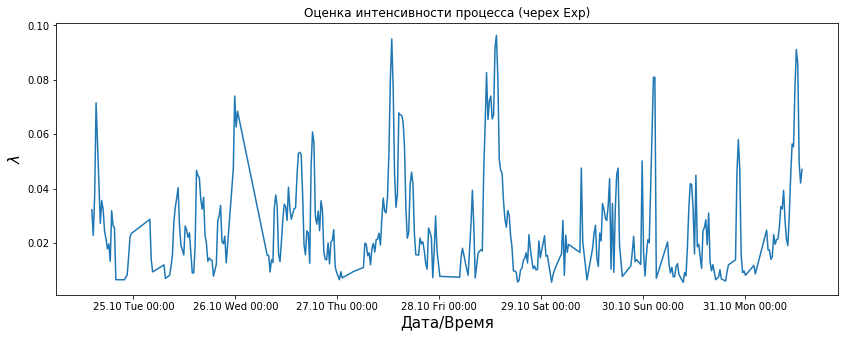

In [59]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%d.%m %a %H:%M")

how_many = 7* 24 * 60  # неделя
step = 24 * 60  # сутки
start_time = times[0]
plt.figure(figsize=(14, 5))
which = lambdas_exp[:, 1] -times[0] < how_many * 60
plt.plot((lambdas_exp[which, 1] - times[0])/60, lambdas_exp[which, 0])
plt.xlabel("Дата/Время", fontsize=15)
plt.ylabel(r"$\lambda$", fontsize=15)
plt.title("Оценка интенсивности процесса (черех Exp)")
labels = [format_time(x) for x in start_time +
          np.arange(24*60 - (13*60 + 41), np.arange(how_many)[-1], step)*60] 
# 13:41 - время первого запроса. Мы хотим подписи в 00:00 часов каждого дня
plt.xticks(np.arange(24*60 - (13*60 + 41), np.arange(how_many)[-1], step), labels)
plt.show()

**Дополнительно:** (Второй способ оценки) Для распределения пуассона ОМП $\lambda = \overline{X}$
Так как $(N_{t+T} - N_{t}) \sim Pois(\lambda(T))$, то разделяя всё время на промежутки по T, оценку интенсивности можно произвести так:
$\forall t \in [t_0, t_0 + T]: \lambda(t) = \overline{X} / T$, где $X = \{X_{-k}, X_{-k+1}, ... X_{+k-1}\}, X_i = N_{t_0+Ti} - N_{t_0 + T (i-1)}$  При это ясно, что $X_i$ можно вычислить один раз (для вычисления $\lambda^*(t_0 + T)$ индексы $X_i $ сдвинулись на один.)

In [324]:
T = 60  # минута
times = data["timestamp"].values

deltas = np.zeros(int((times[-1] - times[0]) / T + 0.5))  # математическое округление
for t in times:
    deltas[(t - times[0])//T] += 1
    # deltas - Xi из условия - считаем число событий за минуту.

In [325]:
deltas

array([ 2.,  4.,  0., ...,  2.,  0.,  1.])

In [326]:
lambdas = [deltas[t - T//2: t + T//2].mean() / T
           if t >= T//2 else 0 for t in range(0, len(deltas) - T//2)]
# на каждую минуту, усредняя по часу (k = 30), начиная
# с 30-й минуты. Первые 30 значений заполним нулями,
# чтобы упростить визуализацию

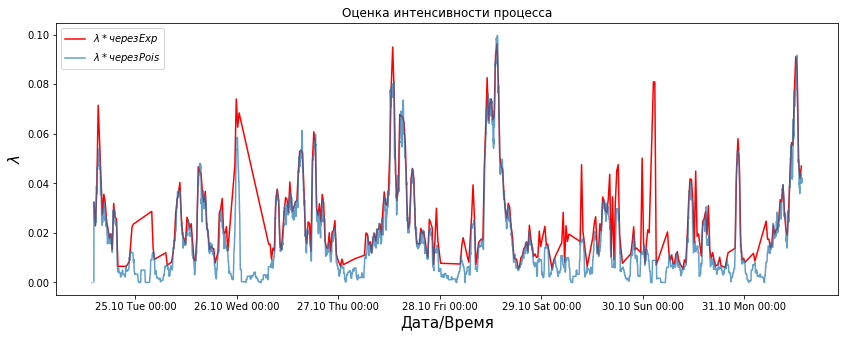

In [63]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%d.%m %a %H:%M")

def plot_lambdas(how_many, step, plot=True, day_label=True):
    start_time = times[0]
    plt.figure(figsize=(14, 5))

    which = lambdas_exp[:, 1] -times[0] < how_many * 60
    if plot:
        plt.plot((lambdas_exp[which, 1] - times[0])/60,
                    lambdas_exp[which, 0],
                    label=r"$\lambda* через Exp$", color="red")
    else:
        plt.scatter((lambdas_exp[which, 1] - times[0])/60,
                    lambdas_exp[which, 0],
                    label=r"$\lambda* через Exp$", color="red")
        
    plt.plot(np.arange(how_many), lambdas[:how_many],
             label=r"$\lambda* через Pois$", alpha=0.7)
    plt.plot(np.arange(30), lambdas[:30], color="white", alpha=0.7)  # а вот и нет нулей.))
    plt.xlabel("Дата/Время", fontsize=15)
    plt.ylabel(r"$\lambda$", fontsize=15)
    plt.title("Оценка интенсивности процесса")
    if day_label:
        labels = [format_time(x) for x in start_time +
                  np.arange(24*60 - (13*60 + 41), np.arange(how_many)[-1], step)*60] 
        plt.xticks(np.arange(24*60 - (13*60 + 41), np.arange(how_many)[-1], step), labels)
    else:
        labels = [format_time(x) for x in start_time + np.arange(0, how_many, step)*60] 
        plt.xticks(np.arange(0, how_many, step), labels)
    plt.legend()
    plt.show()
    
how_many = 7* 24 * 60  # неделя
step = 24 * 60  # сутки

plot_lambdas(how_many, step)

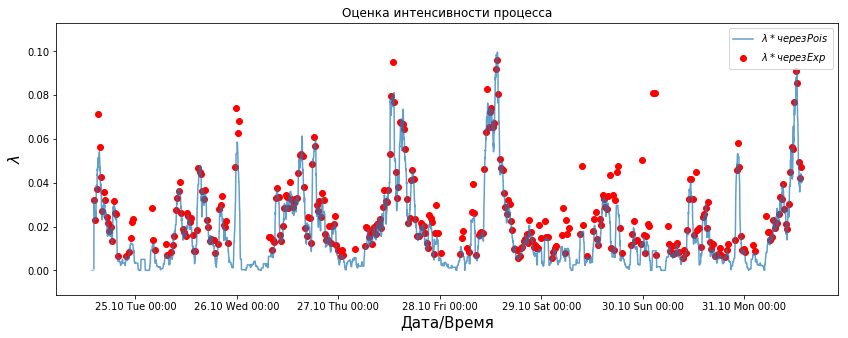

In [64]:
plot_lambdas(how_many, step, plot=False)

**Комментарий:** Очевидна зависимость интенсивности как от времени суток, так и от дня недели: в выходные интенсивность растёт днём меньше, чем в рабочие дни. Две оценки схожи во многом, но из-за того, что мы оцениваем неоднородный процесс, считая его однородным на интервале, оценки, сделанные в двух близких точках могут сильно различаться, а времена в корорые мы делаем оценки и отрезки для двух методов не совпадают, из-за этого наблюдается несовпадение графиков (они используют разный шаг)

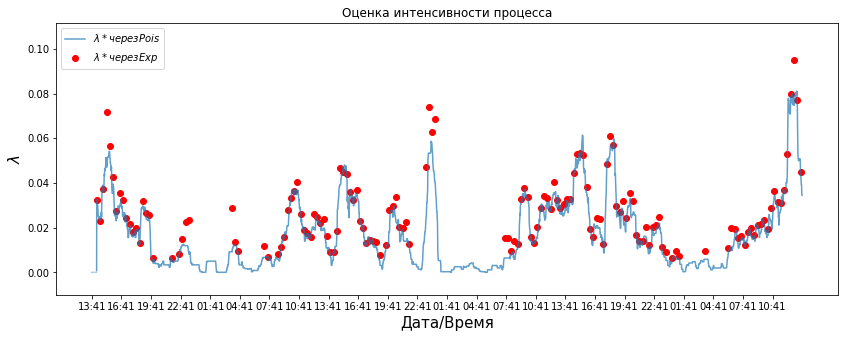

In [65]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%H:%M")

how_many = 3 * 24 * 60  # день
step = 3 * 60  # час

plot_lambdas(how_many, step, plot=False, day_label=False)

**Комментарий:** Видно, что максимумы интенсивностей приходятся на середину рабочего дня - около 14 - 15 часов дня.

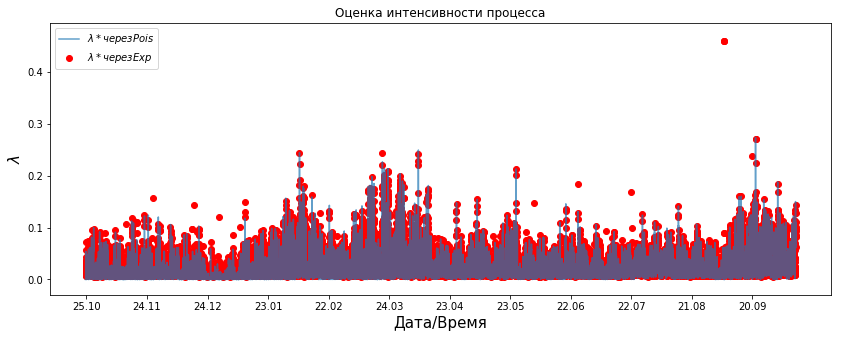

In [66]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%d.%m")

how_many = len(lambdas) 
step = 30 * 24 * 60  # сутки
plot_lambdas(how_many, step, plot=False)

**Комментарий:**
На полном графике по всем данным видно, что в предновогоднюю и посленовогоднюю неделю интенсивность падает, что очевидно.
Видны также черты (в среднем четыре на месяц) - выходные дни.

Понятно, что выводы в целом очевидны, ведь запросы - HTTP requests to the University of Calgary's Department of Computer Science WWW server located at Calgary, Alberta, Canada - и понятно, что в выходные и ночью запросов должно быть много меньше. (Вот только на личном примере эти утверждения опровергаются.)

**Дополнительно:** Проверим, есть ли зависимость интенсивности от типа хоста.

In [75]:
times = data["timestamp"].values
times_local = times[data["host_making"] == "local"]
times_remote = times[data["host_making"] == "remote"]
times_local.sort()
times_remote.sort()
assert (len(times_local) + len(times_remote) == len(times))

Будем действовать так: раз известно, что наши данные цикличны по времени суток и дням недели, проверим, что распределение запросов в разные промежутки времени в течение дня совпадает для локальных и удалённых запросов c помощью критерия хи-квадрат

In [136]:
def test_equality(a, b, bins, log=True):
    a_hist = np.histogram(a, bins=bins)[0]
    b_hist = np.histogram(b, bins=bins)[0]
    b_hist = b_hist / len(b_hist) * len(a_hist)
    if log:
        print(a_hist, b_hist)
    return chisquare_format(sps.chisquare(a_hist, b_hist), log=log)

Посмотрим, верно ли это для первого дня.

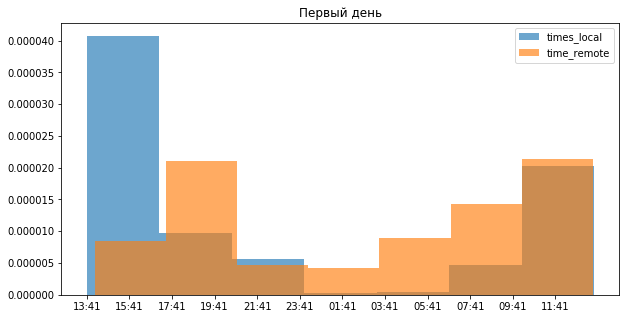

[379  90  52   2   4  44 189] [  47.  116.   26.   23.   49.   79.  118.]
Статистика критерия хи-квадрат: 2495.746
p-value:  0.0
Гипотеза отвергается.


True

In [153]:
def format_time(x):
    dt = datetime.fromtimestamp(x)
    return dt.strftime("%H:%M")
def time_slice_shifted(jumps, a, b):
    """Возвращает элементы jumps,
    корые лежат во временном промежутке times[0] + [a, b)"""
    return jumps[ (a + times[0] <= jumps)  & (jumps < b + times[0])]

day = 24 * 60 * 60 
def plot_day(shift = 0, title="", plot=True, log=True):
    bins = 7
    if plot:
        plt.figure(figsize=(10, 5))
        plt.title(title)
        plt.hist(time_slice_shifted(times_local, shift, shift + day),
                 label="times_local", alpha=0.65, bins=bins, normed=True)
        plt.hist(time_slice_shifted(times_remote, shift, shift + day),
                 label="time_remote", alpha=0.65, bins=bins, normed=True)
        labels = [format_time(x) for x in times[0]
                  + np.arange(shift, shift + day, 2 * 60 * 60)] 
        plt.xticks(times[0]  +np.arange(shift, shift + day, 2 * 60 * 60), labels)
        plt.legend()
        plt.show()
    return test_equality(time_slice_shifted(times_local, shift, shift + day),
                  time_slice_shifted(times_remote, shift, shift + day), bins, log=log)
    
plot_day(title="Первый день")

Видно, что распределения разные - локальные запросы чаще всего приходят в два-четыре часа дня и почти никогда ночью. Удалённые же запросы более равномерны и их максимумы приходятся на вечер 18-20 часов и утро 10-12 часов. (Действительно, кто хочет сидеть на работе ночью)

Посмотри на ещё один день проверим для множества дней, применяя поправку методом Бонферрони и корректируя раз

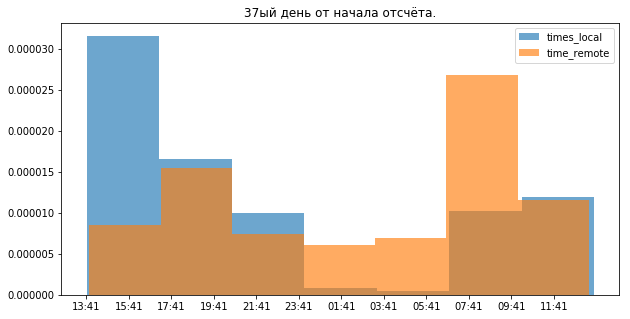

[254 133  80   7   4  82  96] [ 31.  56.  27.  22.  25.  97.  42.]
Статистика критерия хи-квадрат: 1913.689
p-value:  0.0
Гипотеза отвергается.


True

In [154]:
plot_day(shift = 37*day, title="37ый день от начала отсчёта.")

In [155]:
def pvals_plot_day(shift = 0):
    bins = 7
    size_correction = (300, 100)
    a_slice = time_slice_shifted(times_local, shift, shift + day)
    b_slice = time_slice_shifted(times_remote, shift, shift + day)
    if (len(a_slice) > size_correction[0]):
        a_slice = np.array(
            a_slice[sps.randint.rvs(0, len(a_slice), size=size_correction[1])]
        )
    if (len(b_slice) > size_correction[0]):
        b_slice = np.array(
            b_slice[sps.randint.rvs(0, len(b_slice), size=size_correction[1])]
        )
    a_hist = np.histogram(a_slice, bins=bins)[0]
    b_hist = np.histogram(b_slice, bins=bins)[0]
    b_hist = b_hist / len(b_hist) * len(a_hist)

    return sps.chisquare(a_hist, b_hist).pvalue

N = 100
shifts = sps.randint.rvs(times[0] // day, (times[-1] - day - 1) // day, size=N)

rejected = 0
not_rejected = 0
pvals = []
for start_shift in shifts:
    if ((time_slice_shifted(times_local, shift, shift + day).sum() > 1000) and
        (time_slice_shifted(times_remote, shift, shift + day).sum() > 1000)):
        pvals.append(pvals_plot_day(shift = start_shift))

    
ret = multipletests(pvals, alpha=0.05, method='bonferroni')[0]
print("Отвергнуто {} раз из {} ({}%)".format(
    ret.sum(), len(ret), round(ret.sum()/ len(ret) * 100, 2)))

Отвергнуто 92 раз из 100 (92.0%)


Уверенно отвергаем гипотезу о прямой связи (т.е. о равенстве) интесивностей для запросов внутренних и внешних  в произвольный день (может быть, это верно для выходных, или при более сложных условиях). Как говорилось выше, они меняются по разной логике, т.е. можно было выделить два отдельных процесса - внешние и внутренние запросы и оценивать их интенсивность отдельно - они различны!

**Дополнительно:** Исследуем наличие прямой зависимости объёма запроса в байтах от времени. (Не среднее число переданных байт за промежуток времени, а среднее число байт в запросе)
Сначала подсчитаем среднее число байт, переданных за некоторый промежуток времени и сравним его с интенсивностью.

In [322]:
times = data["timestamp"].values
rbytes = data["reply_bytes"].values
step = 20 * 60  # 10 minute
l = 0
r = l
lp = 0 
mean_rbytes = []
while (r < len(times)):  # метод двух указателей
    while (len(times) > r) and (times[l] + step > times[r]):
        r += 1
    mean_rbytes.append((rbytes[l:r].mean(), times[l]))    
    l = r
    if (lp + 100000 < l):
        print(l, end=",")
        lp = l
mean_rbytes = np.array(mean_rbytes) 
 # print(mean_rbytes)

100024,200030,300047,400097,500128,600133,700149,

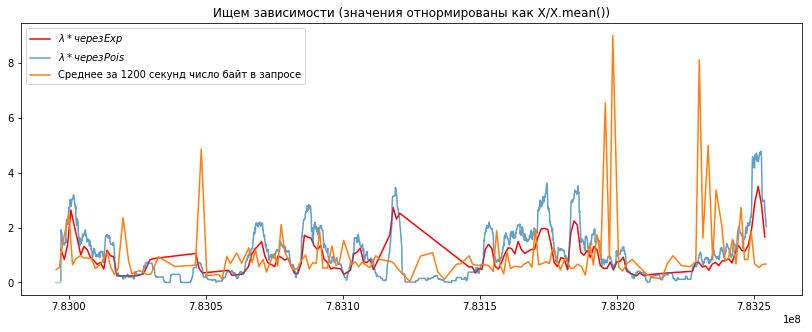

In [327]:
how_many = 3 * 24 * 60 * 60
plt.figure(figsize=(14, 5))

plt.title("Ищем зависимости (значения отнормированы как X/X.mean())")
which = lambdas_exp[:, 1] < how_many + times[0]
plt.plot(lambdas_exp[which, 1] ,
         lambdas_exp[which, 0] / lambdas_exp[which, 0].mean(),
         color="red", label=r"$\lambda* через Exp$")

plt.plot(np.arange(how_many//60)*60 + times[0],
         lambdas[:how_many//60] / np.array(lambdas[:how_many//60]).mean(),
         label=r"$\lambda* через Pois$", alpha=0.7)
plt.plot(np.arange(30)*60 + times[0], lambdas[:30], color="white", alpha=0.7)  # а вот и нет нулей.))

plt.plot(mean_rbytes[mean_rbytes[:, 1] < how_many + times[0], 1],
         mean_rbytes[mean_rbytes[:, 1] < how_many + times[0], 0] / 
        mean_rbytes[mean_rbytes[:, 1] < how_many + times[0], 0].mean(),
        label="Среднее за %d секунд число байт в запросе" % step)
plt.legend()
plt.show()

Зависимости не видно. Попробуем посмотреть на передаваемое число байт по часам.

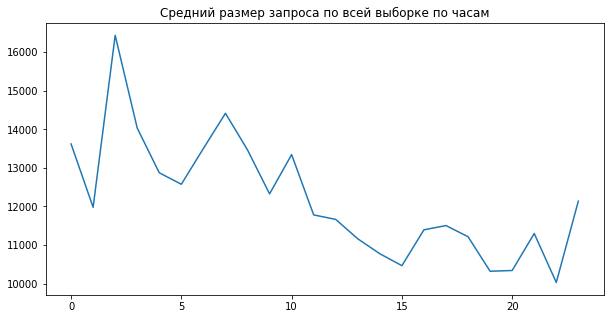

In [264]:
def get_hrs():
    hrs = []
    for i in range(24):
        hrs.append([])
    for i in range(len(times)):
        hrs[(13 + (times[i] - times[0]) // 3600) % 24].append(rbytes[i])
        # первый запрос был в 13:41
    return hrs
        
hrs = get_hrs()
for i in range(len(hrs)):
    hrs[i] = np.array(hrs[i]).mean()

plt.figure(figsize=(10, 5))
plt.title("Средний размер запроса по всей выборке по часам")
plt.plot(np.arange(24), hrs)
plt.show()

Кажется, что зависимость есть. Посмотрим, на сколько она значима. Для этого построим гистиграммы размеров сообщений по часам.

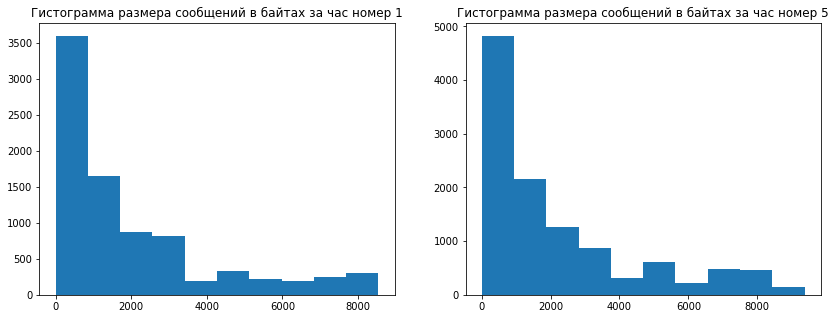

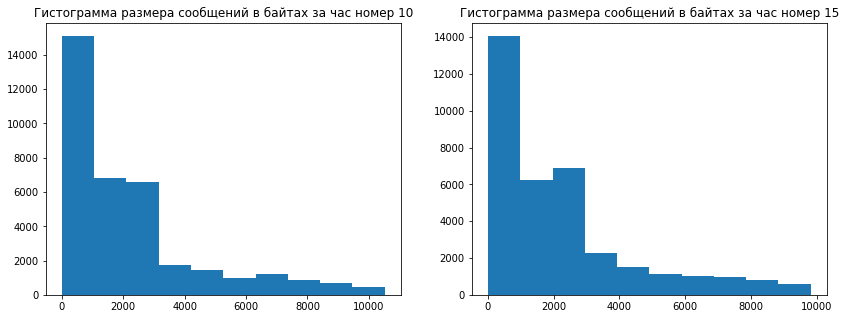

In [298]:
hrs = get_hrs()
for i in range(len(hrs)):
    hrs[i] = np.array(hrs[i])
    
def draw_hist_hr(hour):
    hrs[hour].sort()
    plt.title("Гистограмма размера сообщений в байтах за час номер %d" % (hour))
    plt.hist(hrs[hour][:int(hrs[hour].shape[0] * 0.75)])

plt.figure(figsize=(14, 5))
plt.subplot(121)
draw_hist_hr(1)
plt.subplot(122)
draw_hist_hr(5)
plt.show()

plt.figure(figsize=(14, 5))
plt.subplot(121)
draw_hist_hr(10)
plt.subplot(122)
draw_hist_hr(15)
plt.show()

Они очень похожи. В том числе, кажется, что они экспоненциальны.

In [306]:
pvals = []
for i in range(8):
    exp_params = sps.expon.fit(hrs[i])
    pvals.append(sps.kstest(hrs[i], "expon", args=exp_params).pvalue)
multipletests(pvals, alpha=0.05, method='bonferroni')

(array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 0.0063911509545450107,
 0.00625)

Нет так нет. (гипотеза отвергнута и проверять все часы, судя по pvalue, бессмысленно).  Проверим, насколько похожи распределения по часам похожи друг на друга. Разобьём запросы на 6 категорий по размерам: 0<x<2000, 2000<x<4000, 4000<x<6000, 6000<x<8000, 8000<x<1000, other и подсчитаем, сколько запросов из 150 случайных в каждом часе лежит в каждой категории.

Также вычислим ожидаемое распределение - вычислив среднее распределение среди всех 24 часов и проверим с помощью теста хи-квадрат гипотезу, что выборки в каждый час являются выборками из этого оценённого ожидаемого распределения.

In [318]:
sub_hrs_rbytes_hist = []
N = 150
for i in range(24):
    sub = hrs[i][sps.randint.rvs(0, len(hrs[i]), size=N)]
    sub_hist = np.zeros(6)
    for val in sub:
        sub_hist[min(5, val // 2000)] += 1
    sub_hrs_rbytes_hist.append(sub_hist)
                          
pvals = []
expected = np.zeros(6)
for i in range(24):
    expected += sub_hrs_rbytes_hist[i]
expected /= 24
for i in range(24):
    pvals.append(sps.chisquare(sub_hrs_rbytes_hist[i], expected).pvalue)
        
print("Результаты множественного тестирования для 24 часов " + 
      "(была ли отвергнута гипотеза о том, что выборка для " + 
      "i-го часа является выборкой из ожидаемого распределения):")
multipletests(pvals, alpha=0.05, method='bonferroni')

Результаты множественного тестирования для 24 часов (была ли отвергнута гипотеза о том, что выборка для i-го часа является выборкой из ожидаемого распределения):


(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False], dtype=bool),
 array([ 0.32987055,  1.        ,  1.        ,  1.        ,  1.        ,
         0.57204628,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ]),
 0.0021349383697015778,
 0.0020833333333333333)

 **Вывод:** Это уже значимый результат! Несмотря на то, что число запросов меняется, в зависимости от времени суток, **распределеление размеров запросов от времени суток не зависит** (мы не смогли отвергнуть такую гипотезу ни для одного часа)

**Дополнительно: Оценка пропускной способности** (Грубо. Очень грубо.)

В задании предлагается также оценить пропускную способность, необходимую для сервера, но не сколько не формализуется, что считать пропускной способностью. Будем оценивать её как просто число байт запросов за минуту. (это очень приближённый подход, но без уточнения того, что считать пропускной способностью, будем считать так. Только один выбор метода измерения пропускной способности делает мало осмысленным поиск точной оценки пропускной способности)

Раз мы оценили интенсивнось, возьмём её максимальной значение для оценки выкинем 1% первых значений, считая, что это выбросы - слишком грубо оценённые значения.

In [331]:
temp_lambdas = lambdas
temp_lambdas.sort()
l = temp_lambdas[int(len(temp_lambdas) * .99 + 0.5)]
print("Max (avg.) lambda = ", l)

Max (avg.) lambda =  0.116666666667


Вычислим число запросов за 1 минуту, помня, что прирост распределён пуассоновски и считая, что нам повезло на 1%.

In [351]:
avg_requsts_in_crisis = sps.poisson(l*60).ppf(0.99)
print("Оценка число запросов за минуту в минуты " + 
      "пиковой накрузки, когда не повезло = ", avg_requsts_in_crisis)

Оценка число запросов за минуту в минуты пиковой накрузки, когда не повезло =  14.0


Значение выглядит разумным, если рассмотреть график числа запросов за первые сутки. Считая, что размер сообщения не зависит от времени суток, выберем среднее число байт, переданное в запросе за минуту, считая что нам повезло на 1%

In [348]:
def get_strees_msg_size():
    times = data["timestamp"].values
    rbytes = data["reply_bytes"].values
    step = 1 * 60  # 10 minute
    l = 0
    r = l
    lp = 0 
    mean_rbytes = []
    while (r < len(times)):  # метод двух указателей
        while (len(times) > r) and (times[l] + step > times[r]):
            r += 1
        mean_rbytes.append((rbytes[l:r].mean(), times[l]))    
        l = r
        if (lp + 100000 < l):
            print(l, end=",")
            lp = l
    mean_rbytes.sort()
    return mean_rbytes[int(len(mean_rbytes) * 0.99)][0]

stress_msg_size = get_strees_msg_size()
print("\nсредний за минуту размер сообщения в военное время = ", stress_msg_size)

100003,200008,300009,400014,500021,600024,700026,
средний за минуту размер сообщения в военное время =  263267.0


In [354]:
strees_bytes_per_minute = int(stress_msg_size * avg_requsts_in_crisis + 0.5)
print("Нужно уметь обрабатывать столько байт в минуту = ", strees_bytes_per_minute)
print("Нужно уметь обрабатывать столько МБ в минуту = ", strees_bytes_per_minute / 2**20)

Нужно уметь обрабатывать столько байт в минуту =  3685738
Нужно уметь обрабатывать столько МБ в минуту =  3.514993667602539


**Вывод:** Тогда, считая что интенсивность и размер сообщения независимы, для обеспечения идеальной работоспособности в
$0.99 \cdot 0.99 \sim 0.98$ минутах (интенсивность и средний размер не больше одновременно, чем оценённые) (uptime 98%) (оценка снизу) (пару лет назад вконтакте опускался ниже) нужно уметь обрабатывать 3.515 МБ в минуту, что выглядит правдоподобно, учитывая, что за весь первый день было  < 1.3*1e7 байт (~130 МБ запросов) [Мы не NASA, а всего лишь университетский сервер]